Определение языка (language detection)
--------------------

* **Множество случаев** — тексты на разных языках
* **Множество классов** — языки

## 1. Подготовка данных

In [1]:
import re
import wikipedia
import warnings
warnings.filterwarnings('ignore')

In [13]:
def get_texts_for_lang(lang, n=10, verbose=True): # функция для скачивания статей из википедии
    wikipedia.set_lang(lang)
    wiki_content = []
    cnt = 0
    while len(wiki_content) < n:
        pages = wikipedia.random(n - len(wiki_content))
        
        for page_name in pages:
            try:
                page = wikipedia.page(page_name)
                wiki_content.append('{}\n{}'.format(page.title, page.content.replace('==', '')))
            
            except wikipedia.exceptions.WikipediaException:
                # print('Skipping page {}'.format(page_name))
                continue
    if verbose:
        print('Collected <%s>: %s' % (lang, len(wiki_content)))
    
    return wiki_content

Возьмем английский, французский, итальянский и испанский языки

In [5]:
LANGS = ['en', 'fr', 'it', 'es']

Скачаем статьи для обучения и выгрузим их на диск

In [14]:
%%time

wiki_texts = dict()

for lang in LANGS: 
    wiki_texts[lang] = get_texts_for_lang(lang, 100)

Collected <en>: 100
Collected <fr>: 100
Collected <it>: 100
Collected <es>: 122
Wall time: 13min 44s


In [18]:
for lang in wiki_texts.keys():
    f = open('%s_texts_train' % lang, 'w', encoding='utf-8')
    for t in wiki_texts[lang]:
        f.write('%s\n::SEP::\n' % t)
    f.close()

То же самое для статей для валидации

In [19]:
%%time

wiki_texts_test = dict()

for lang in LANGS: 
    wiki_texts_test[lang] = get_texts_for_lang(lang, 100)

Collected <en>: 100
Collected <fr>: 110
Collected <it>: 100
Collected <es>: 100
Wall time: 14min 1s


In [20]:
for lang in wiki_texts_test.keys():
    f = open('%s_texts_test' % lang, 'w', encoding='utf-8')
    for t in wiki_texts[lang]:
        f.write('%s\n::SEP::\n' % t)
    f.close()

Функционал для загрузки статей с диска

In [13]:
def load_texts(langs):
    """
    return: dicts of train, test texts
    """
    train = dict()
    test = dict()
    template = '%s_tex'
    
    for lang in langs:
        train[lang] = open('%s_texts_train' % lang, 'r', encoding='utf-8').read().split('::SEP::')[:100]
        test[lang] = open('%s_texts_test' % lang, 'r', encoding='utf-8').read().split('::SEP::')[:100]
    
    return train, test

In [14]:
texts_train, texts_test = load_texts(LANGS)

## 2. Построение модели для распознавания языка

Для удобства я реализовал весь требуемый функционал в виде класса `Classifier`<br>
Данный тип позволяет нормализовать входные тектсы, "выучить" распределение слов и n-gram (по умолчанию используется диапазон [2, 5]) для каждого языка и предсказать язык произвольного входного текста<br><br>
Атрибуты:<br>
- `langs`: доступные языки
- `texts`: dict: тексты на разных языках для обучения
- `ngram_range`: диапазон n-gram
- `top_n_grams`: число наиболее частотных n-gram при предсказании
- `word_list`: dict: распределение слов для каждого языка
- `ngram_list`: dict: распределение n-gram для каждого языка


Методы:
- `__normalize`: нормализовать текст
- `fit`: обучить модель на текстах в `self.texts`. Выбор между использованием частотностей слов или n-gram задается параметром `mode`, где `mode='words'` - использовать слова, `mode='ngrams'` - использовать n-gram. При использовании частотностей слов используется логарифм частотности
- `predict`: предсказать язык для произвольного входного текста. Выбор между использованием частотностей слов или n-gram задается аналогично `fit`
- `predict_from_file`: вызвать `predict` для текста из файла по пути `path`

Для построения и упорядочивания распределений использовался удобный функионал `nltk.probability.FreqDist` 

In [84]:
import numpy as np
from nltk.probability import FreqDist
from nltk import ngrams
from copy import deepcopy

In [170]:
class Classifier:
    
    def __init__(self, langs, texts):
        self.langs = langs
        self.texts = deepcopy(texts)
        self.ngram_range = (2, 6)
        self.top_n_ngrams = 300
        
        self.word_list = {lang: None for lang in self.langs}
        self.ngram_list = {lang: None for lang in self.langs}
        self.N_words = {lang: 0 for lang in self.langs}
        
        
        self.__normalize_texts()
        
    def __normalize(self, text):
        norm = list()
        for w in text.split():
            w = re.sub('\\n|\\r', '', w)
            w = re.sub('[0-9]', '', w)
            w = re.sub('^[\W]*', '', w)
            w = re.sub('[\W]*$', '', w)
            w = re.sub(' {2,}', ' ', w)
            w = w.lower()

            if w:
                norm.append(w)

        return ' '.join(norm)
        
    def __calc_total_word_counts(self):
        for lang in self.langs:
            self.N_words[lang] = sum([self.word_list[lang][k] for k in self.word_list[lang].keys()])
            
    def __normalize_texts(self):
        for lang in self.langs:
            self.texts[lang] = [self.__normalize(t) for t in self.texts[lang]]
    
    def __fitWordList(self, texts):
        return FreqDist([w for t in texts for w in t.split()])
    
    def __fitNgramList(self, texts, _range, top_n):
        _ngrams = list()
        
        if isinstance(texts, list):
            texts_merged = ' '.join(texts)
        else:
            texts_merged = texts
            
        for i in range(*_range):
            _ngrams.extend([''.join(x) for x in list(ngrams(texts_merged, i))])
        
        freq = FreqDist(_ngrams).most_common(top_n)
        freq = {x[0]: i + 1 for i, x in enumerate(freq)}
        
        return freq
    
    def fit(self, mode='words', lang=None, ngram_range=(2, 6), top_n_ngrams=300):
        
        assert mode in ['words', 'ngrams']
        
        self.ngram_range = ngram_range
        self.top_n_ngrams = top_n_ngrams
        
        if lang is not None:
            
            assert lang in self.langs
            
            if mode == 'words':
                self.word_list[lang] = self.__fitWordList(self.texts[lang])
            else:
                self.ngram_list[lang] = self.__fitNgramList(self.texts[lang], ngram_range, top_n_ngrams)
                
        else:
            for lang in self.langs:
                if mode == 'words':
                    self.word_list[lang] = self.__fitWordList(self.texts[lang])
                else:
                    self.ngram_list[lang] = self.__fitNgramList(self.texts[lang], ngram_range, top_n_ngrams)
        
        if mode == 'words':
            self.__calc_total_word_counts()
            
    def predict(self, text, mode='words'):

        assert mode in ['words', 'ngrams']

        res = {lang: 0 for lang in self.langs}

        _text = self.__normalize(text)

        if mode == 'words':
            for w in _text.split():
                for lang in self.langs:
                    fr = self.word_list[lang].get(w)

                    if fr is None:
                        fr = 0

                    res[lang] += np.log1p(fr / self.N_words[lang])

            return max(res, key=res.get)

        else:

            _text_ngrams = self.__fitNgramList(_text, self.ngram_range, self.top_n_ngrams)

            for lang in self.langs:
                dist = 0
                for ngram in _text_ngrams:
                    global_rank = self.ngram_list[lang].get(ngram)

                    if global_rank is not None:
                        dist += abs(global_rank - _text_ngrams[ngram])

                    else:
                        dist += len(_text_ngrams)

                res[lang] = dist

            return min(res, key=res.get)
        
    def predict_from_file(self, path, mode='words'):
        text = open(path, 'r', encoding='utf-8').read()
        pred = self.predcit(text, mode)
        
        return pred

Создадим модель

In [171]:
clf = Classifier(LANGS, texts_train)

Обучим модель сразу двумя методами

In [172]:
clf.fit(mode='words')

In [173]:
clf.fit(mode='ngrams')

Предсказание

In [200]:
clf.predict(texts_test['it'][50], mode='words')

'it'

Действительно, итальянский

## 3. Оценка качества

Для оценки качества использовались предсказания, полученные обоими методами, на валидационных текстах, которые модель "не видела" при "обучении"<br>
Были получены значения точности, а также был проведен анализ матриц ошибок, полученных с помощью функционала `sklearn.metrics.confusion_matrix`

In [203]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [206]:
def evaluate(model, texts, n=100):
    word_level_res = {lang: None for lang in LANGS}
    ngram_level_res = {lang: None for lang in LANGS}
    
    for lang in LANGS:
        word_level_pred = [model.predict(text, mode='words') for text in texts[lang][:n]]
        ngram_level_pred = [model.predict(text, mode='ngrams') for text in texts[lang][:n]]
        
        word_level_res[lang] = word_level_pred.count(lang) / len(word_level_pred)
        ngram_level_res[lang] = ngram_level_pred.count(lang) / len(ngram_level_pred)
    
    return word_level_res, ngram_level_res


def get_predictions(model, texts, n=100):
    mask = {lang: i for i, lang in enumerate(LANGS)}
    word_level_pred = {lang: None for lang in LANGS}
    ngram_level_pred = {lang: None for lang in LANGS}
    
    for lang in LANGS:
        word_level_pred[lang] = [mask[model.predict(text, mode='words')] for text in texts[lang][:n]]
        ngram_level_pred[lang] = [mask[model.predict(text, mode='ngrams')] for text in texts[lang][:n]]
    
    return word_level_pred, ngram_level_pred, mask

Получим значения точности для обоих методов

In [194]:
acc_word_level, acc_ngram_level = evaluate(clf, texts_test, n=100)

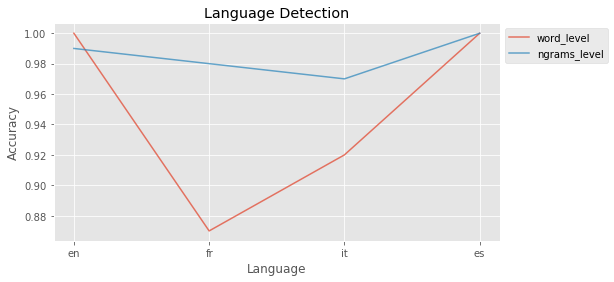

In [199]:
plt.figure(figsize=(8, 4))

labels = ['word_level', 'ngrams_level']

for i, preds in enumerate([acc_word_level, acc_ngram_level]):
    plt.plot(range(4), [preds[lang] for lang in LANGS], label=labels[i], alpha=0.75)

plt.xticks(range(4), LANGS)
plt.legend(bbox_to_anchor=(1, 1))
plt.title('Language Detection')
plt.xlabel('Language')
plt.ylabel('Accuracy')

Видно, что оба метода показали вполне хорошее качество<br>
В то же время, использование n-gram дает общее качество, близкое к идеальному, и более высокое, чем при использовании частотностей слов, что кажется естественным, так как на таком малом наборе данных (всего по 100) информации об различных n-gram много больше, чем информации о самих словах<br>
Касательно языков, видно, что испанский является единственным языком безошибочно классифицируемым с помощью обоих методов<br>
Не менее хорошо выделяется и английский язык<br>
Некоторые проблемы имеются при выделении итальянских и особенно французских текстов с помощью частотностей слов<br>
Думаю, это можно объяснить малым количеством данных для использования метода с частотностями слов, а также генетической принадлежностью данных языков к единой ветви (в этом отношении немного неожиданно, что испанский так точно выделяется)

Построим и рассмотрим матрицы ошибок

In [207]:
word_level_pred, ngram_level_pred, mask = get_predictions(clf, texts_test, n=100)

In [208]:
mask

{'en': 0, 'es': 3, 'fr': 1, 'it': 2}

In [217]:
for lang in LANGS:
    print('language: %s' % lang)
    print('word_level:\n', confusion_matrix([mask[lang] for _ in range(100)], word_level_pred[lang], labels=[0, 1 , 2, 3]))
    print('\nngram_level:\n', confusion_matrix([mask[lang] for _ in range(100)], ngram_level_pred[lang], labels=[0, 1 , 2, 3]))
    print('\n')

language: en
word_level:
 [[100   0   0   0]
 [  0   0   0   0]
 [  0   0   0   0]
 [  0   0   0   0]]

ngram_level:
 [[99  0  1  0]
 [ 0  0  0  0]
 [ 0  0  0  0]
 [ 0  0  0  0]]


language: fr
word_level:
 [[ 0  0  0  0]
 [ 2 87  0 11]
 [ 0  0  0  0]
 [ 0  0  0  0]]

ngram_level:
 [[ 0  0  0  0]
 [ 2 98  0  0]
 [ 0  0  0  0]
 [ 0  0  0  0]]


language: it
word_level:
 [[ 0  0  0  0]
 [ 0  0  0  0]
 [ 5  0 92  3]
 [ 0  0  0  0]]

ngram_level:
 [[ 0  0  0  0]
 [ 0  0  0  0]
 [ 2  0 97  1]
 [ 0  0  0  0]]


language: es
word_level:
 [[  0   0   0   0]
 [  0   0   0   0]
 [  0   0   0   0]
 [  0   0   0 100]]

ngram_level:
 [[  0   0   0   0]
 [  0   0   0   0]
 [  0   0   0   0]
 [  0   0   0 100]]




Видим, что английский однажды на уровне n-gram был ошибочно определен как итальянский (что интересно)<br>
Французский чаще всего неверно определялся как испанский (11 раз) на уровне слов и реже как английский (2 раза). Интересно, что на уровне n-gram было сделано всего 2 ошибки в сторону английского (что кажется естественным)<br>
Итальянский чаще определялся как английский и реже как испанский (близость с испанским ясна, интересно также и наличие ошибок в сторону английского)